# Changepoint Detection in presence of outliers
### Alexis Groshenry - Grégoire Dutot

## This notebook is meant to be run on google colab

In [37]:
!pip install ruptures

In [ ]:
import datetime as dt
from math import log

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import ruptures as rpt
from ruptures.base import BaseCost
from ruptures.metrics import hausdorff
from scipy.stats import ttest_ind
from scipy.optimize import minimize, root
from tqdm import tqdm
from time import time
from sklearn.metrics import adjusted_rand_score

import warnings
warnings.filterwarnings("ignore")

In [39]:
## Utils
def fig_ax(nrows=1, figsize=(15, 5)):
    return plt.subplots(nrows=nrows, figsize=(figsize[0], figsize[1] * nrows))

## R-FPOP implementation

We implemented a heap structure to efficiently store, read and write the piecewise quadratic writing of the cost objective.

A quadratic function $q_i$ is coded by an object `Node` defined by its `start` and `end` points and its coefficients `[a2,a1,a0]` such that $q_i(\theta)=a_2 \theta^2 + a_1\theta + a_0$.

It also has a `child` and a `father` field which verify : `self.end==self.child.start` and `self.start==self.father.end`.

We define the methods `split` and `merge` to modify the elements of the heap, while keeping its structure consistent.

In [40]:
class Node():
    def __init__(self, start, end, coeffs: np.ndarray, change_point=None):
        self.start = start # start of the interval
        self.end = end # end of the interval
        self.coeffs = coeffs # [a2, a1, a0]
        self.change_point = change_point
        self.child = None
        self.father = None

    def func(self, theta):
        return (self.coeffs * theta ** np.arange(2,-1,-1)).reshape(-1,3).sum(axis=1)

    def set_child(self, ChildNode):
        self.child = ChildNode
        ChildNode.father = self

    def set_father(self, FatherNode):
        self.father = FatherNode
        FatherNode.child = self

    def merge(self):
        '''merge a Node with its child'''
        if self.change_point!=self.child.change_point:
            # this should not happen but on thousands of runs it happened once
            return
        self.end = self.child.end
        self.child = self.child.child # WARNING potential memory leak? no idea how python handle the intermediate point

    def split(self, mid, coeffs, after=True):
        # change_point?
        if after:
            # new coeffs after mid
            new = Node(mid, self.end, coeffs)
        else:
            # new coeffs before mid
            new = Node(mid, self.end, self.coeffs)
            self.coeffs = coeffs
        self.end = mid
        new.set_child(self.child)
        self.set_child(new)

class ChainedList():
    def __init__(self, start, end, coeffs, change_point=None):
        self.root = Node(start, end, coeffs, change_point)
        self.length = 1    

    def simplify(self):
        current_node = self.root
        n_changes = 0
        while current_node!=None and current_node.child!=None:
            if (current_node.coeffs==current_node.child.coeffs).all():
                current_node.merge()
                n_changes += 1
            current_node = current_node.child
        self.length -= n_changes

    def plot(self):
        current_node = self.root
        while current_node!=None:
            x = np.linspace(current_node.start, current_node.end, 100)
            plt.plot(x,current_node.func(x.reshape(-1,1)))
            #plt.axvline(current_node.start)
            current_node = current_node.child
        plt.show()

In [41]:
def compute_Q_theta(Q_star: ChainedList, Gamma: ChainedList):
    current_node_qstar = Q_star.root
    current_node_gamma = Gamma.root
    define_root = True
    
    while current_node_qstar!=None and current_node_gamma!=None:
        start = max(current_node_qstar.start, current_node_gamma.start)
        end = min(current_node_qstar.end, current_node_gamma.end)

        if define_root:
            Q_theta = ChainedList(
                start,
                end,
                current_node_qstar.coeffs+current_node_gamma.coeffs,
                current_node_qstar.change_point
            )
            current_node_q = Q_theta.root
            define_root = False
        else:
            current_node_q.set_child(Node(
                start,
                end,
                current_node_qstar.coeffs+current_node_gamma.coeffs,
                current_node_qstar.change_point
            ))
            current_node_q = current_node_q.child
            Q_theta.length += 1
        
        if current_node_qstar.end == current_node_q.end:
            current_node_qstar = current_node_qstar.child
        else:
            current_node_gamma = current_node_gamma.child

    return Q_theta


def min_best_change(Q_theta: ChainedList):
    current_node_q = Q_theta.root
    Q = np.inf
    tau_t = 0
    while current_node_q!=None:
        m = minimize(
            current_node_q.func,
            current_node_q.start,
            bounds=((current_node_q.start, current_node_q.end),)
        ).fun[0]
        if m < Q:
            Q = m
            tau_t = current_node_q.change_point
        current_node_q = current_node_q.child
    return (Q, tau_t)

def compute_Q_star(Q_theta: ChainedList, C, t):
    eps = 1e-3 # to avoid numeric approximation errors
    current_node_q = Q_theta.root
    define_root = True
    while current_node_q!=None:
        R_tmp = np.roots(current_node_q.coeffs - np.array([0,0,C]))
        R_tmp.sort()
        R = [current_node_q.start]
        for root in R_tmp:
            if root > current_node_q.start + eps and root < current_node_q.end - eps and not np.iscomplex(root):
                R.append(root)
        R.append(current_node_q.end)
        for j in range(len(R)-1):
            start = R[j]
            end = R[j+1]
            # on this interval, Q_t(theta) has a constant sign
            if current_node_q.func((start+end)/2) > C:
                coeffs = np.array([0,0,C])
                change_point = t
            else:
                coeffs = current_node_q.coeffs.copy()
                change_point = current_node_q.change_point
            
            if define_root:
                Q_star = ChainedList(
                    start,
                    end,
                    coeffs,
                    change_point
                )
                current_node_q_star = Q_star.root
                define_root = False
            else:
                current_node_q_star.set_child(Node(
                    start,
                    end,
                    coeffs,
                    change_point
                ))
                current_node_q_star = current_node_q_star.child
                Q_star.length += 1
        current_node_q = current_node_q.child
    return Q_star

In [42]:
def rfpop(signal, pen, thresh):
    n = signal.shape[0]
    Q_star = ChainedList(
        signal.min(),
        signal.max(),
        coeffs = np.zeros(3)
    )
    change_points = []
    nb_intervals = []
    for t in tqdm(range(n)):
        # compute gamma(y_t, theta)
        # \theta**2 - 2*y_t*\theta + y_t**2
        R_tmp = np.roots(np.array([1,-2*signal[t],signal[t]**2]) - np.array([0,0,thresh**2]))
        R_tmp.sort()
        R = [signal.min()]
        for root in R_tmp:
            if root > signal.min() and root < signal.max() and root==np.real(root):
                R.append(root)
        R.append([signal.max()])
        for idx in range(len(R)-1):
            if (signal[t] - (R[idx]+R[idx+1])/2)**2 < thresh**2:
                coeffs = np.array([1,-2*signal[t],signal[t]**2])
            else:
                coeffs = np.array([0,0,thresh**2])
            if not idx:
                Gamma = ChainedList(
                    R[idx],
                    R[idx+1],
                    coeffs
                )
                current_node_gamma = Gamma.root
            else:
                current_node_gamma.set_child(Node(
                    R[idx],
                    R[idx+1],
                    coeffs
                ))
                current_node_gamma = current_node_gamma.child
        #Gamma.plot()
        Q_theta = compute_Q_theta(Q_star, Gamma)
        Q, tau = min_best_change(Q_theta)
        change_points.append((Q,tau))
        Q_star = compute_Q_star(Q_theta,Q+pen, t)
        Q_star.simplify()
        # Q_theta.plot()
        # Q_star.plot()
        nb_intervals.append(Q_star.length)
    return change_points, nb_intervals

# Artificial outliers

### Generating data

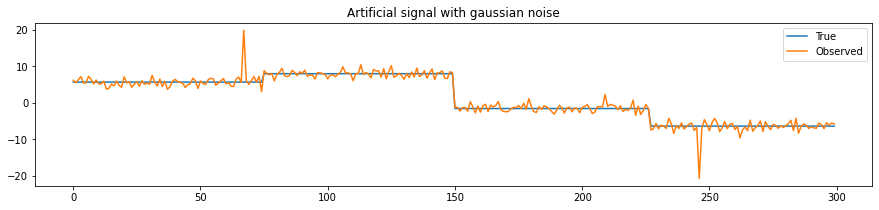

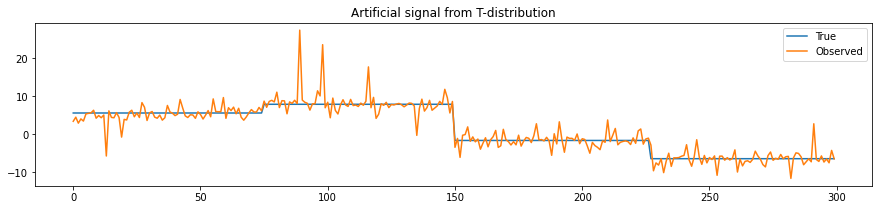

In [46]:
# generate signal
n_samples = 300
n_bkps = 3 #10
n_dims = 1
noise_std = 1
seed_noise = 42
np.random.seed(seed_noise)


def fig_ax(figsize=(15, 3)):
    return plt.subplots(figsize=figsize)


def generate_signal_normal(n_samples, n_bkps, n_dims, noise_std, outlier_ratio, outlier_mult_factor, plot=False):
    signal_clean, bkps = rpt.pw_constant(
        n_samples=n_samples, n_features=n_dims, n_bkps=n_bkps, noise_std=0, seed=1
    )
    signal = signal_clean + np.random.normal(
        scale=noise_std, size=signal_clean.shape
    )

    n_outliers = int(n_samples * outlier_ratio)
    idx = np.random.choice(n_samples, n_outliers, replace=False)
    signal[idx] *= outlier_mult_factor

    if plot:
        fig, ax = fig_ax()
        ax.plot(signal_clean, label="True")
        ax.plot(signal, label="Observed")
        ax.set_title('Artificial signal with gaussian noise')
        _ = plt.legend()
        plt.show()
        
    return signal, bkps


def generate_signal_t_distrib(n_samples, n_bkps, n_dims, dof, plot=False):
    signal_clean, bkps = rpt.pw_constant(
        n_samples=n_samples, n_features=n_dims, n_bkps=n_bkps, noise_std=0, seed=1
    )
    noise = np.random.standard_t(dof, size=signal_clean.shape)
    signal = signal_clean + noise

    if plot:
        fig, ax = fig_ax()
        ax.plot(signal_clean, label="True")
        ax.plot(signal, label="Observed")
        ax.set_title('Artificial signal from T-distribution')
        _ = plt.legend()
        plt.show()

    return signal, bkps


def classify(bkps, signal):
    classification = np.zeros(len(signal))
    classification[:bkps[0]] = 0
    for i in range(len(bkps)-1):
      classification[bkps[i]:bkps[i+1]] = i+1
    classification[bkps[-1]:] = len(bkps)-1
    return classification


def eval_segmentation(true_bkps, pred_bkps, signal):
    true_seg = classify(true_bkps, signal)
    pred_seg = classify(pred_bkps, signal)
    return adjusted_rand_score(true_seg, pred_seg)


signal_g, bkps_g = generate_signal_normal(n_samples, n_bkps, n_dims, noise_std, outlier_ratio=0.01, outlier_mult_factor=3, plot=True)
signal_t, bkps_t = generate_signal_t_distrib(n_samples, n_bkps, n_dims, 2, plot=True)

### PELT algorithm + L2 loss

error: 21.0 samples
rand index: 0.8942166268534935


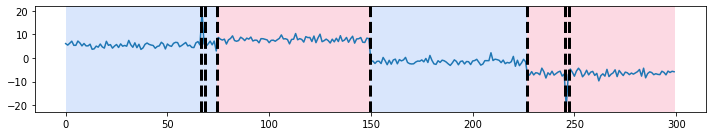

In [47]:
pen_bic = 2 * np.log(n_samples) * noise_std**2 
predicted_bkps_g = rpt.Pelt(model="l2", jump=1).fit_predict(
    signal=signal_g, pen=pen_bic
)

fig, ax_arr = rpt.display(signal_g, bkps_g, predicted_bkps_g)
print(f"error: {hausdorff(bkps_g, predicted_bkps_g)} samples")
print(f"rand index: {eval_segmentation(bkps_g, predicted_bkps_g, signal_g)}")

error: 66.0 samples
rand index: 0.5418851364898999


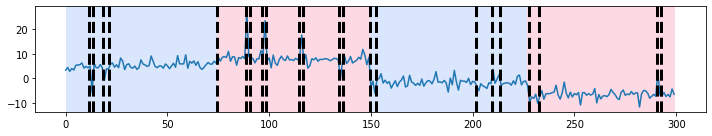

In [48]:
pen_bic = 2 * np.log(n_samples) * noise_std**2 
predicted_bkps_t = rpt.Pelt(model="l2", jump=1).fit_predict(
    signal=signal_t, pen=pen_bic
)

fig, ax_arr = rpt.display(signal_t, bkps_t, predicted_bkps_t)
print(f"error: {hausdorff(bkps_t, predicted_bkps_t)} samples")
print(f"rand index: {eval_segmentation(bkps_t, predicted_bkps_t, signal_t)}")

### PELT Algorithm + Biweight loss

In [49]:
class BiweightCost(BaseCost):

    """Biweight cost"""

    model = "Biweight"
    

    def __init__(self, thresh):
        """Initialize the object."""
        self.signal = None
        self.min_size = 2
        self.thresh = thresh

    def fit(self, signal):
        """Set the internal parameter."""
        self.signal = signal
        return self

    def error(self, start, end):
        """Return the approximation cost on the segment [start:end].

        Args:
            start (int): start of the segment
            end (int): end of the segment

        Returns:
            float: segment cost
        """
        sub = self.signal[start:end]
        l2_dist = sub.var(axis=0) * (end-start)
        constant = np.ones(sub.shape) * self.thresh**2
        mask = (l2_dist > self.thresh**2).astype(int)
        return (mask*constant + (1-mask)*l2_dist).mean()

error: 55.0 samples
rand index: 0.8069076444554724


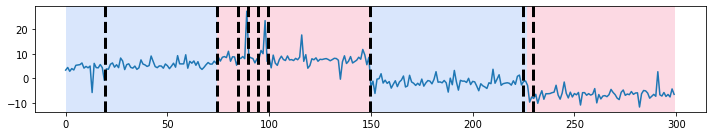

In [51]:
pen_bic = 2 * np.log(n_samples) * noise_std**2 
predicted_bkps_t = rpt.Pelt(custom_cost=BiweightCost(3*pen_bic)).fit_predict(
    signal=signal_t, pen=pen_bic
)

fig, ax_arr = rpt.display(signal_t, bkps_t, predicted_bkps_t)
print(f"error: {hausdorff(bkps_t, predicted_bkps_t)} samples")
print(f"rand index: {eval_segmentation(bkps_t, predicted_bkps_t, signal_t)}")

Using the biweight loss brings a bit more robustness but the results are still not satisfying. It also seems that the fitting of the threshold parameter follows *ad hoc* rules with PELT.

### R-FPOP

100%|██████████| 300/300 [00:02<00:00, 148.56it/s]


error: 1.0 samples
rand index: 0.9732483027554987


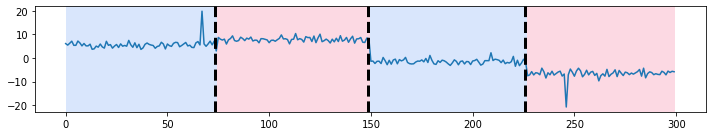

In [53]:
var_g = noise_std**2
cp_g, _ = rfpop(signal_g, var_g*70, 3*np.sqrt(var_g))

cp_g = np.array(cp_g)[:,1]
cp_g[np.where(cp_g == None)] = 0
predicted_bkps_g = np.unique(cp_g)[1:]
predicted_bkps_g = np.hstack((predicted_bkps_g, n_samples))

fig, ax_arr = rpt.display(signal_g, bkps_g, predicted_bkps_g)
print(f"error: {hausdorff(bkps_g, predicted_bkps_g)} samples")
print(f"rand index: {eval_segmentation(bkps_g, predicted_bkps_g, signal_g)}")

100%|██████████| 300/300 [00:02<00:00, 122.86it/s]


error: 3.0 samples
rand index: 0.9733750722955723


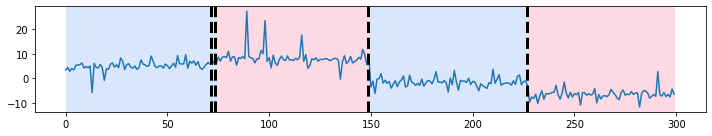

In [54]:
var_t = noise_std**2
cp_t, _ = rfpop(signal_t, var_t*70, 3*np.sqrt(var_t))

cp_t = np.array(cp_t)[:,1]
cp_t[np.where(cp_t == None)] = 0
predicted_bkps_t = np.unique(cp_t)[1:]
predicted_bkps_t = np.hstack((predicted_bkps_t, n_samples))

fig, ax_arr = rpt.display(signal_t, bkps_t, predicted_bkps_t)
print(f"error: {hausdorff(bkps_t, predicted_bkps_t)} samples")
print(f"rand index: {eval_segmentation(bkps_t, predicted_bkps_t, signal_t)}")

The results are very satisfying with almost no mistake.

### Extensive comparison of the 3 approaches

**WARNING** : the cells in the following section take up to several minutes to run

In the following section, we compare the 3 previous approaches on several signals generated from a T-distribution for different values of the number of degrees of freedom.

In [68]:
# generate signal
n_samples = 300
n_bkps = 3
n_dims = 1
noise_std = 1
seed_noise = 42
np.random.seed(seed_noise)

dic_res = {
    'rand_pelt' : [],
    'haus_pelt' : [],
    'rand_pelt_bi' : [],
    'haus_pelt_bi' : [],
    'rand_rfpop' : [],
    'haus_rfpop' : [],
    }

for dof in range(1,21):
  print('\nNumber of degree of freedom {}'.format(dof))
  for _ in range(25):

    # Generate signal
    signal, bkps = generate_signal_t_distrib(n_samples, n_bkps, n_dims, dof)
    d_signal = np.array([signal[i+1]-signal[i] for i in range(len(signal)-1)])
    sigma_hat = np.median(np.abs(d_signal - np.median(d_signal)))
    pen_bic = 2 * np.log(n_samples) * sigma_hat**2 
    K = 3 * sigma_hat
    # PELT
    predicted_bkps = rpt.Pelt(custom_cost=BiweightCost(K)).fit_predict(
        signal=signal, pen=pen_bic
    )
    try:
      dic_res['haus_pelt_bi'].append(hausdorff(bkps, predicted_bkps))
    except ValueError:
      dic_res['haus_pelt_bi'].append(300)
    dic_res['rand_pelt_bi'].append(eval_segmentation(bkps, predicted_bkps, signal))


    # PELT with L2
    predicted_bkps = rpt.Pelt(model="l2", jump=1).fit_predict(
        signal=signal, pen=pen_bic
    )
    try:
      dic_res['haus_pelt'].append(hausdorff(bkps, predicted_bkps))
    except ValueError:
      dic_res['haus_pelt'].append(300)
    dic_res['rand_pelt'].append(eval_segmentation(bkps, predicted_bkps, signal))

    # RFPOP
    cp,_ = rfpop(signal, pen_bic, K) 
    cp = np.array(cp)[:,1]
    cp[np.where(cp == None)] = 0
    predicted_bkps = np.unique(cp)[1:]
    predicted_bkps = np.hstack((predicted_bkps,signal.shape[0]))

    dic_res['haus_rfpop'].append(hausdorff(bkps, predicted_bkps))
    dic_res['rand_rfpop'].append(eval_segmentation(bkps, predicted_bkps, signal))




Number of degree of freedom 1


100%|██████████| 300/300 [00:01<00:00, 213.68it/s]



Number of degree of freedom 2


100%|██████████| 300/300 [00:01<00:00, 241.01it/s]



Number of degree of freedom 3


100%|██████████| 300/300 [00:01<00:00, 219.62it/s]



Number of degree of freedom 4


100%|██████████| 300/300 [00:01<00:00, 243.93it/s]



Number of degree of freedom 5


100%|██████████| 300/300 [00:01<00:00, 263.23it/s]



Number of degree of freedom 6


100%|██████████| 300/300 [00:01<00:00, 243.78it/s]



Number of degree of freedom 7


100%|██████████| 300/300 [00:01<00:00, 258.67it/s]



Number of degree of freedom 8


100%|██████████| 300/300 [00:02<00:00, 110.10it/s]



Number of degree of freedom 9


100%|██████████| 300/300 [00:01<00:00, 231.91it/s]



Number of degree of freedom 10


100%|██████████| 300/300 [00:01<00:00, 249.72it/s]



Number of degree of freedom 11


100%|██████████| 300/300 [00:01<00:00, 248.01it/s]



Number of degree of freedom 12


100%|██████████| 300/300 [00:01<00:00, 224.72it/s]



Number of degree of freedom 13


100%|██████████| 300/300 [00:02<00:00, 133.05it/s]



Number of degree of freedom 14


100%|██████████| 300/300 [00:02<00:00, 143.50it/s]



Number of degree of freedom 15


100%|██████████| 300/300 [00:01<00:00, 257.88it/s]



Number of degree of freedom 16


100%|██████████| 300/300 [00:01<00:00, 262.11it/s]



Number of degree of freedom 17


100%|██████████| 300/300 [00:01<00:00, 245.72it/s]



Number of degree of freedom 18


100%|██████████| 300/300 [00:01<00:00, 258.11it/s]



Number of degree of freedom 19


100%|██████████| 300/300 [00:01<00:00, 239.03it/s]



Number of degree of freedom 20


100%|██████████| 300/300 [00:01<00:00, 234.58it/s]


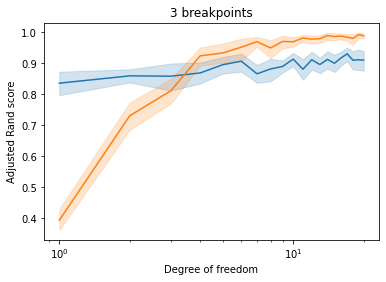

In [70]:
df = pd.DataFrame(dic_res)
l = []
for dof in range(1, 21):
  for _ in range(25):
    l.append(dof)
df['dof'] = l

sns.lineplot(data = df, x='dof', y='rand_rfpop')
sns.lineplot(data = df, x='dof', y='rand_pelt')
plt.title('3 breakpoints')
plt.ylabel('Adjusted Rand score')
plt.xlabel('Degree of freedom')

plt.xscale('log')

### Study of the Computational Cost 

We have a closer look in this part to the space and time complexity of the method and how the different hyperparameters influence it.

100%|██████████| 300/300 [00:00<00:00, 348.81it/s]


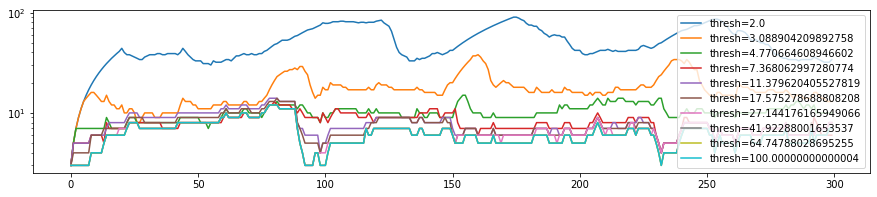

In [60]:
fig, ax = fig_ax()
list_mult = np.exp(np.linspace(np.log(2), np.log(100), 10))
for thresh in list_mult:
    _,nb_intervals = rfpop(signal_t, 10*np.log(n_samples), thresh)
    ax.plot(np.arange(n_samples), nb_intervals, label='thresh={}'.format(thresh))
ax.legend()
ax.set_yscale('log')
plt.show()

100%|██████████| 300/300 [00:03<00:00, 94.65it/s] 


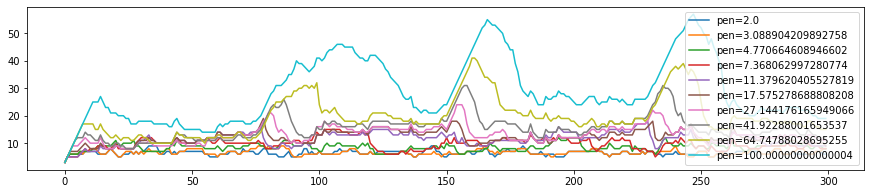

In [64]:
fig, ax = fig_ax()
list_mult = np.exp(np.linspace(np.log(2), np.log(100), 10))
for pen in list_mult:
    _,nb_intervals = rfpop(signal_t, pen, 3)
    ax.plot(np.arange(n_samples), nb_intervals, label='pen={}'.format(pen))
ax.legend()
plt.show()

From the previous graphs, we can conclude that the influence of the $\beta$ and $K$ parameters are opposed : increasing $\beta$ leads to an increased space and time complexity, while it is the opposite for $K$.

### Study of the choice of parameters on performance

**WARNING** : the cells in the following section take up to several hours to run

In [79]:
# generate signal
n_samples = 300
n_bkps = 3
n_dims = 1
noise_std = 1
seed_noise = 42
np.random.seed(seed_noise)
list_mult = np.exp(np.linspace(np.log(0.1), np.log(10), 20))


dic_res = {
    'rand_rfpop' : [],
    'haus_rfpop' : [],
    'pen_mult' : [],
    'thresh_mult' : []
    }

for i,pen_mult in enumerate(list_mult):
  print('{} iteration out of 20'.format(i+1))
  for thresh_mult  in list_mult:

    # Generate signal
    signal, bkps = generate_signal_t_distrib(n_samples, n_bkps, n_dims, 2)
    d_signal = np.array([signal[i+1]-signal[i] for i in range(len(signal)-1)])
    sigma_hat = np.median(np.abs(d_signal - np.median(d_signal)))
    pen_bic = 2 * np.log(n_samples) * sigma_hat**2 * pen_mult
    K = 3 * sigma_hat * thresh_mult
    
    # RFPOP
    cp, _ = rfpop(signal, pen_bic, K)
    cp = np.array(cp)[:,1]
    cp[np.where(cp == None)] = 0
    predicted_bkps = np.unique(cp)[1:]
    predicted_bkps = np.hstack((predicted_bkps,signal.shape[0]))

    dic_res['rand_rfpop'].append(eval_segmentation(bkps, predicted_bkps, signal))
    dic_res['pen_mult'].append(pen_mult)
    dic_res['thresh_mult'].append(thresh_mult)




1 iteration out of 20


100%|██████████| 300/300 [00:00<00:00, 416.75it/s]


2 iteration out of 20


100%|██████████| 300/300 [00:00<00:00, 338.28it/s]


3 iteration out of 20


100%|██████████| 300/300 [00:00<00:00, 404.01it/s]


4 iteration out of 20


100%|██████████| 300/300 [00:00<00:00, 377.83it/s]


5 iteration out of 20


100%|██████████| 300/300 [00:00<00:00, 379.16it/s]


6 iteration out of 20


100%|██████████| 300/300 [00:00<00:00, 368.68it/s]


7 iteration out of 20


100%|██████████| 300/300 [00:00<00:00, 360.45it/s]


8 iteration out of 20


100%|██████████| 300/300 [00:00<00:00, 351.06it/s]


9 iteration out of 20


100%|██████████| 300/300 [00:00<00:00, 357.76it/s]


10 iteration out of 20


100%|██████████| 300/300 [00:00<00:00, 383.65it/s]


11 iteration out of 20


100%|██████████| 300/300 [00:00<00:00, 376.19it/s]


12 iteration out of 20


100%|██████████| 300/300 [00:00<00:00, 325.90it/s]


13 iteration out of 20


100%|██████████| 300/300 [00:00<00:00, 362.89it/s]


14 iteration out of 20


100%|██████████| 300/300 [00:00<00:00, 371.76it/s]


15 iteration out of 20


100%|██████████| 300/300 [00:00<00:00, 359.78it/s]


16 iteration out of 20


100%|██████████| 300/300 [00:00<00:00, 387.73it/s]


17 iteration out of 20


100%|██████████| 300/300 [00:00<00:00, 342.60it/s]


18 iteration out of 20


100%|██████████| 300/300 [00:00<00:00, 303.29it/s]


19 iteration out of 20


100%|██████████| 300/300 [00:00<00:00, 395.73it/s]


20 iteration out of 20


100%|██████████| 300/300 [00:00<00:00, 337.41it/s]


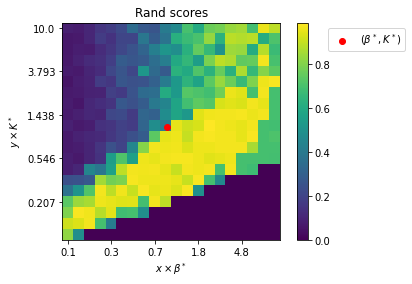

In [85]:
df3 = pd.DataFrame(dic_res)
tab = pd.pivot_table(df3[['rand_rfpop', 'pen_mult', 'thresh_mult']], values='rand_rfpop', columns='pen_mult', index='thresh_mult')

plt.imshow(tab.sort_values(by='thresh_mult', ascending=False))
plt.xticks(np.arange(20)[::4], [round(mult, 1) for mult in list_mult][::4])
plt.yticks(np.arange(20)[::4], [round(mult, 3) for mult in list_mult][::-4])
plt.colorbar()
plt.title('Rand scores')
plt.xlabel('$x \\times \\beta^*$')
plt.ylabel('$y \\times K^*$')
plt.scatter([9.1053], [9.1053], c='r', label='$(\\beta^*, K^*)$')
plt.legend(loc='upper right', bbox_to_anchor=[1.6, 1.])
plt.show()

# Well-log dataset

The dataset is available on https://github.com/alan-turing-institute/rbocpdms/tree/master/Data.

In [71]:
!gdown --id 189Zaj1-1L4Qq2kUgq6iFKAztCSR6U0Fb

Downloading...
From: https://drive.google.com/uc?id=189Zaj1-1L4Qq2kUgq6iFKAztCSR6U0Fb
To: /content/well.txt
100% 56.7k/56.7k [00:00<00:00, 58.0MB/s]


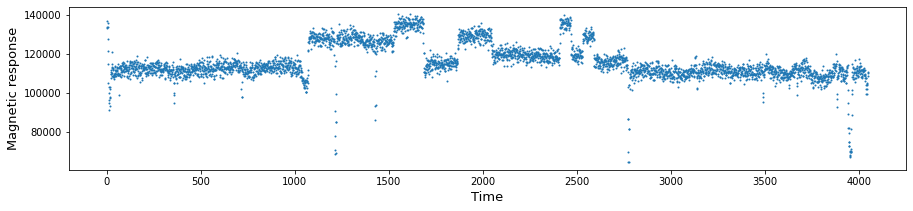

In [72]:
well_log = np.array(open('well.txt').readlines()).astype(float)
fig,ax = fig_ax()
ax.scatter(np.arange(4050), well_log, s=1)
ax.set_xlabel('Time', size=13)
ax.set_ylabel('Magnetic response', size=13)
plt.show()

We compute the variance of noise in the signal by differentiation.

In [73]:
var = np.array([well_log[i+1]-well_log[i] for i in range(4049)]).var()

### PELT algorithm

computed in 19.064758777618408


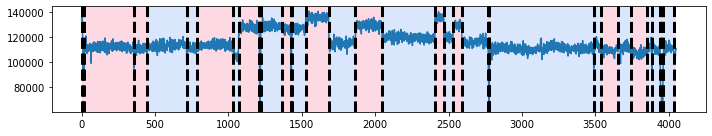

In [74]:
pen_bic = 2 * np.log(4050) * var
start = time()
predicted_bkps = rpt.Pelt(model="l2", jump=1).fit_predict(
    signal=well_log, pen=pen_bic
)
print('computed in {}'.format(time()-start))
fig, ax_arr = rpt.display(well_log, predicted_bkps, predicted_bkps)

### Outlier removal and PELT algorithm

For comparison purposes, we try here to remove outliers using a quantile-based approach before performing a change point detection with PELT algorithm.

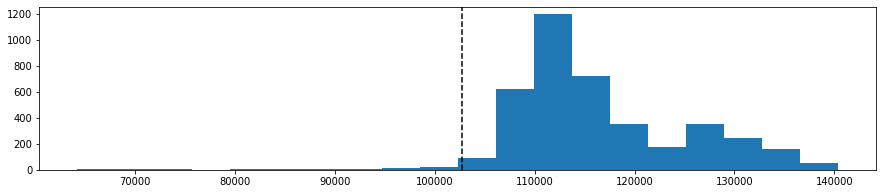

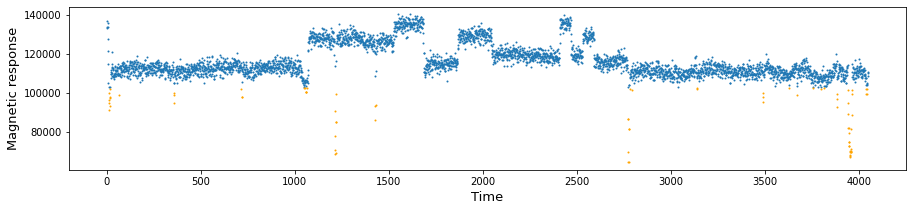

In [75]:
quantile_threshold_low = 0.02

fig, ax = fig_ax()
_ = ax.hist(well_log, 20)

threshold_low = np.quantile(
    well_log, [quantile_threshold_low]
)
_ = ax.axvline(threshold_low, ls="--", color="k")
plt.show()

fig,ax = fig_ax()
ax.scatter(np.arange(4050)[well_log>threshold_low], well_log[well_log> threshold_low], s=1)
ax.scatter(np.arange(4050)[well_log<threshold_low], well_log[well_log< threshold_low], s=1, color='orange')
ax.set_xlabel('Time', size=13)
ax.set_ylabel('Magnetic response', size=13)
plt.show()

computed in 26.933120727539062


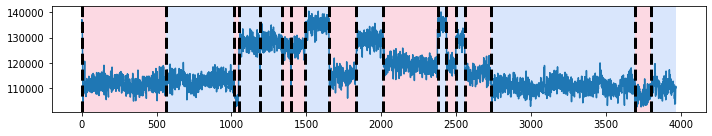

In [76]:
pen_bic = 2 * np.log(4050) * var 
start = time()
predicted_bkps = rpt.Pelt(model="l2", jump=1).fit_predict(
    signal=well_log[well_log>threshold_low], pen=pen_bic
)
print('computed in {}'.format(time()-start))
fig, ax_arr = rpt.display(well_log[well_log>threshold_low], predicted_bkps, predicted_bkps)

The results are better than without any preprocessing, but since the outliers with non aberrant values are not removed with this quantile approach, the remaining outliers are still considered as change points.

### R-FPOP

100%|██████████| 4050/4050 [00:24<00:00, 163.24it/s]


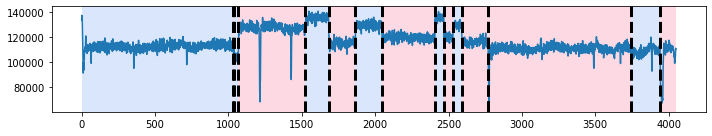

In [77]:
cp, _ = rfpop(well_log, var*70, 3*np.sqrt(var))

cp = np.array(cp)[:,1]
cp[np.where(cp == None)] = 0
predicted_bkps = np.unique(cp)[1:]
predicted_bkps = np.hstack((predicted_bkps,well_log.shape[0]))

fig, ax_arr = rpt.display(well_log, predicted_bkps, predicted_bkps)

### Online analysis

**WARNING** : the cells in the following section take up to an hour to run

In [89]:
last_change_detected = []
change_points = []
list_t = []
for t in range(1360, 2750, 10):
  print('Time {} over 2750'.format(t))
  partial_signal = well_log[1350:t].copy()

  # Parameter definition
  d_signal = np.array([partial_signal[i+1]-partial_signal[i] for i in range(len(partial_signal)-1)])
  sigma_hat = np.median(np.abs(d_signal - np.median(d_signal)))
  pen_bic = 70 * sigma_hat**2 
  K = 2 * sigma_hat 

  #R-FPOP
  cp,_ = rfpop(partial_signal, pen_bic, K)
  cp = np.array(cp)[:,1]
  cp[np.where(cp == None)] = 0
  predicted_bkps = np.unique(cp)[1:]
  predicted_bkps = np.hstack((predicted_bkps, partial_signal.shape[0]))
  change_points.append(cp)
  list_t.append(t)
  if len(cp) >1:
    last_change_detected.append(cp[-1])
  else: 
    last_change_detected.append(0)

Time 1360 over 2750


100%|██████████| 10/10 [00:00<00:00, 538.16it/s]


Time 1370 over 2750


100%|██████████| 20/20 [00:00<00:00, 110.64it/s]


Time 1380 over 2750


100%|██████████| 30/30 [00:00<00:00, 67.23it/s]


Time 1390 over 2750


100%|██████████| 40/40 [00:00<00:00, 48.18it/s]


Time 1400 over 2750


100%|██████████| 50/50 [00:00<00:00, 93.69it/s]


Time 1410 over 2750


100%|██████████| 60/60 [00:00<00:00, 98.51it/s]


Time 1420 over 2750


100%|██████████| 70/70 [00:00<00:00, 94.00it/s]


Time 1430 over 2750


100%|██████████| 80/80 [00:00<00:00, 89.60it/s]


Time 1440 over 2750


100%|██████████| 90/90 [00:01<00:00, 84.66it/s]


Time 1450 over 2750


100%|██████████| 100/100 [00:01<00:00, 74.33it/s]


Time 1460 over 2750


100%|██████████| 110/110 [00:01<00:00, 78.08it/s]


Time 1470 over 2750


100%|██████████| 120/120 [00:01<00:00, 74.30it/s]


Time 1480 over 2750


100%|██████████| 130/130 [00:01<00:00, 77.54it/s]


Time 1490 over 2750


100%|██████████| 140/140 [00:01<00:00, 79.29it/s]


Time 1500 over 2750


100%|██████████| 150/150 [00:01<00:00, 75.35it/s]


Time 1510 over 2750


100%|██████████| 160/160 [00:02<00:00, 67.90it/s]


Time 1520 over 2750


100%|██████████| 170/170 [00:02<00:00, 63.91it/s]


Time 1530 over 2750


100%|██████████| 180/180 [00:03<00:00, 59.68it/s]


Time 1540 over 2750


100%|██████████| 190/190 [00:02<00:00, 65.00it/s]


Time 1550 over 2750


100%|██████████| 200/200 [00:03<00:00, 63.69it/s]


Time 1560 over 2750


100%|██████████| 210/210 [00:03<00:00, 62.18it/s]


Time 1570 over 2750


100%|██████████| 220/220 [00:03<00:00, 62.31it/s]


Time 1580 over 2750


100%|██████████| 230/230 [00:03<00:00, 62.10it/s]


Time 1590 over 2750


100%|██████████| 240/240 [00:03<00:00, 65.56it/s]


Time 1600 over 2750


100%|██████████| 250/250 [00:03<00:00, 72.03it/s]


Time 1610 over 2750


100%|██████████| 260/260 [00:03<00:00, 67.74it/s]


Time 1620 over 2750


100%|██████████| 270/270 [00:04<00:00, 64.31it/s]


Time 1630 over 2750


100%|██████████| 280/280 [00:04<00:00, 65.16it/s]


Time 1640 over 2750


100%|██████████| 290/290 [00:04<00:00, 65.68it/s]


Time 1650 over 2750


100%|██████████| 300/300 [00:04<00:00, 66.44it/s]


Time 1660 over 2750


100%|██████████| 310/310 [00:04<00:00, 67.31it/s]


Time 1670 over 2750


100%|██████████| 320/320 [00:04<00:00, 66.13it/s]


Time 1680 over 2750


100%|██████████| 330/330 [00:04<00:00, 68.22it/s]


Time 1690 over 2750


100%|██████████| 340/340 [00:04<00:00, 69.26it/s]


Time 1700 over 2750


100%|██████████| 350/350 [00:05<00:00, 66.60it/s]


Time 1710 over 2750


100%|██████████| 360/360 [00:05<00:00, 67.78it/s]


Time 1720 over 2750


100%|██████████| 370/370 [00:05<00:00, 67.68it/s]


Time 1730 over 2750


100%|██████████| 380/380 [00:05<00:00, 67.39it/s]


Time 1740 over 2750


100%|██████████| 390/390 [00:05<00:00, 65.80it/s]


Time 1750 over 2750


100%|██████████| 400/400 [00:06<00:00, 64.51it/s]


Time 1760 over 2750


100%|██████████| 410/410 [00:06<00:00, 64.51it/s]


Time 1770 over 2750


100%|██████████| 420/420 [00:06<00:00, 63.82it/s]


Time 1780 over 2750


100%|██████████| 430/430 [00:06<00:00, 64.07it/s]


Time 1790 over 2750


100%|██████████| 440/440 [00:07<00:00, 60.48it/s]


Time 1800 over 2750


100%|██████████| 450/450 [00:07<00:00, 62.89it/s]


Time 1810 over 2750


100%|██████████| 460/460 [00:07<00:00, 61.36it/s]


Time 1820 over 2750


100%|██████████| 470/470 [00:07<00:00, 62.55it/s]


Time 1830 over 2750


100%|██████████| 480/480 [00:07<00:00, 62.43it/s]


Time 1840 over 2750


100%|██████████| 490/490 [00:08<00:00, 59.15it/s]


Time 1850 over 2750


100%|██████████| 500/500 [00:08<00:00, 59.47it/s]


Time 1860 over 2750


100%|██████████| 510/510 [00:09<00:00, 54.46it/s]


Time 1870 over 2750


100%|██████████| 520/520 [00:08<00:00, 58.36it/s]


Time 1880 over 2750


100%|██████████| 530/530 [00:09<00:00, 57.46it/s]


Time 1890 over 2750


100%|██████████| 540/540 [00:09<00:00, 56.99it/s]


Time 1900 over 2750


100%|██████████| 550/550 [00:09<00:00, 57.34it/s]


Time 1910 over 2750


100%|██████████| 560/560 [00:09<00:00, 57.14it/s]


Time 1920 over 2750


100%|██████████| 570/570 [00:10<00:00, 56.17it/s]


Time 1930 over 2750


100%|██████████| 580/580 [00:10<00:00, 57.03it/s]


Time 1940 over 2750


100%|██████████| 590/590 [00:10<00:00, 57.58it/s]


Time 1950 over 2750


100%|██████████| 600/600 [00:10<00:00, 57.73it/s]


Time 1960 over 2750


100%|██████████| 610/610 [00:10<00:00, 56.12it/s]


Time 1970 over 2750


100%|██████████| 620/620 [00:10<00:00, 57.60it/s]


Time 1980 over 2750


100%|██████████| 630/630 [00:11<00:00, 56.91it/s]


Time 1990 over 2750


100%|██████████| 640/640 [00:10<00:00, 59.09it/s]


Time 2000 over 2750


100%|██████████| 650/650 [00:11<00:00, 58.66it/s]


Time 2010 over 2750


100%|██████████| 660/660 [00:11<00:00, 57.20it/s]


Time 2020 over 2750


100%|██████████| 670/670 [00:11<00:00, 60.03it/s]


Time 2030 over 2750


100%|██████████| 680/680 [00:11<00:00, 59.33it/s]


Time 2040 over 2750


100%|██████████| 690/690 [00:11<00:00, 59.90it/s]


Time 2050 over 2750


100%|██████████| 700/700 [00:11<00:00, 60.30it/s]


Time 2060 over 2750


100%|██████████| 710/710 [00:11<00:00, 60.05it/s]


Time 2070 over 2750


100%|██████████| 720/720 [00:11<00:00, 60.03it/s]


Time 2080 over 2750


100%|██████████| 730/730 [00:12<00:00, 60.57it/s]


Time 2090 over 2750


100%|██████████| 740/740 [00:12<00:00, 58.83it/s]


Time 2100 over 2750


100%|██████████| 750/750 [00:12<00:00, 58.50it/s]


Time 2110 over 2750


100%|██████████| 760/760 [00:12<00:00, 58.60it/s]


Time 2120 over 2750


100%|██████████| 770/770 [00:13<00:00, 57.50it/s]


Time 2130 over 2750


100%|██████████| 780/780 [00:13<00:00, 59.03it/s]


Time 2140 over 2750


100%|██████████| 790/790 [00:13<00:00, 58.96it/s]


Time 2150 over 2750


100%|██████████| 800/800 [00:13<00:00, 59.30it/s]


Time 2160 over 2750


100%|██████████| 810/810 [00:13<00:00, 59.11it/s]


Time 2170 over 2750


100%|██████████| 820/820 [00:13<00:00, 59.39it/s]


Time 2180 over 2750


100%|██████████| 830/830 [00:14<00:00, 58.54it/s]


Time 2190 over 2750


100%|██████████| 840/840 [00:13<00:00, 61.13it/s]


Time 2200 over 2750


100%|██████████| 850/850 [00:14<00:00, 60.14it/s]


Time 2210 over 2750


100%|██████████| 860/860 [00:14<00:00, 59.31it/s]


Time 2220 over 2750


100%|██████████| 870/870 [00:14<00:00, 59.97it/s]


Time 2230 over 2750


100%|██████████| 880/880 [00:14<00:00, 60.94it/s]


Time 2240 over 2750


100%|██████████| 890/890 [00:14<00:00, 60.05it/s]


Time 2250 over 2750


100%|██████████| 900/900 [00:15<00:00, 59.81it/s]


Time 2260 over 2750


100%|██████████| 910/910 [00:15<00:00, 58.34it/s]


Time 2270 over 2750


100%|██████████| 920/920 [00:15<00:00, 60.69it/s]


Time 2280 over 2750


100%|██████████| 930/930 [00:15<00:00, 59.96it/s]


Time 2290 over 2750


100%|██████████| 940/940 [00:16<00:00, 58.72it/s]


Time 2300 over 2750


100%|██████████| 950/950 [00:15<00:00, 59.78it/s]


Time 2310 over 2750


100%|██████████| 960/960 [00:15<00:00, 60.24it/s]


Time 2320 over 2750


100%|██████████| 970/970 [00:16<00:00, 58.92it/s]


Time 2330 over 2750


100%|██████████| 980/980 [00:16<00:00, 60.68it/s]


Time 2340 over 2750


100%|██████████| 990/990 [00:16<00:00, 61.50it/s]


Time 2350 over 2750


100%|██████████| 1000/1000 [00:16<00:00, 59.64it/s]


Time 2360 over 2750


100%|██████████| 1010/1010 [00:16<00:00, 61.23it/s]


Time 2370 over 2750


100%|██████████| 1020/1020 [00:16<00:00, 62.06it/s]


Time 2380 over 2750


100%|██████████| 1030/1030 [00:16<00:00, 62.89it/s]


Time 2390 over 2750


100%|██████████| 1040/1040 [00:16<00:00, 62.86it/s]


Time 2400 over 2750


100%|██████████| 1050/1050 [00:16<00:00, 62.62it/s]


Time 2410 over 2750


100%|██████████| 1060/1060 [00:17<00:00, 61.27it/s]


Time 2420 over 2750


100%|██████████| 1070/1070 [00:17<00:00, 61.19it/s]


Time 2430 over 2750


100%|██████████| 1080/1080 [00:17<00:00, 61.47it/s]


Time 2440 over 2750


100%|██████████| 1090/1090 [00:17<00:00, 60.80it/s]


Time 2450 over 2750


100%|██████████| 1100/1100 [00:17<00:00, 62.60it/s]


Time 2460 over 2750


100%|██████████| 1110/1110 [00:18<00:00, 60.56it/s]


Time 2470 over 2750


100%|██████████| 1120/1120 [00:18<00:00, 60.50it/s]


Time 2480 over 2750


100%|██████████| 1130/1130 [00:18<00:00, 62.29it/s]


Time 2490 over 2750


100%|██████████| 1140/1140 [00:18<00:00, 60.84it/s]


Time 2500 over 2750


100%|██████████| 1150/1150 [00:21<00:00, 54.23it/s]


Time 2510 over 2750


100%|██████████| 1160/1160 [00:18<00:00, 61.58it/s]


Time 2520 over 2750


100%|██████████| 1170/1170 [00:19<00:00, 61.32it/s]


Time 2530 over 2750


100%|██████████| 1180/1180 [00:20<00:00, 57.02it/s]


Time 2540 over 2750


100%|██████████| 1190/1190 [00:23<00:00, 50.43it/s]


Time 2550 over 2750


100%|██████████| 1200/1200 [00:19<00:00, 62.11it/s]


Time 2560 over 2750


100%|██████████| 1210/1210 [00:20<00:00, 57.69it/s]


Time 2570 over 2750


100%|██████████| 1220/1220 [00:19<00:00, 62.19it/s]


Time 2580 over 2750


100%|██████████| 1230/1230 [00:19<00:00, 62.25it/s]


Time 2590 over 2750


100%|██████████| 1240/1240 [00:19<00:00, 62.13it/s]


Time 2600 over 2750


100%|██████████| 1250/1250 [00:22<00:00, 55.86it/s]


Time 2610 over 2750


100%|██████████| 1260/1260 [00:20<00:00, 62.11it/s]


Time 2620 over 2750


100%|██████████| 1270/1270 [00:20<00:00, 62.16it/s]


Time 2630 over 2750


100%|██████████| 1280/1280 [00:20<00:00, 61.36it/s]


Time 2640 over 2750


100%|██████████| 1290/1290 [00:21<00:00, 60.36it/s]


Time 2650 over 2750


100%|██████████| 1300/1300 [00:21<00:00, 60.74it/s]


Time 2660 over 2750


100%|██████████| 1310/1310 [00:21<00:00, 61.81it/s]


Time 2670 over 2750


100%|██████████| 1320/1320 [00:21<00:00, 61.50it/s]


Time 2680 over 2750


100%|██████████| 1330/1330 [00:21<00:00, 61.59it/s]


Time 2690 over 2750


100%|██████████| 1340/1340 [00:22<00:00, 60.84it/s]


Time 2700 over 2750


100%|██████████| 1350/1350 [00:22<00:00, 60.60it/s]


Time 2710 over 2750


100%|██████████| 1360/1360 [00:22<00:00, 60.97it/s]


Time 2720 over 2750


100%|██████████| 1370/1370 [00:22<00:00, 60.16it/s]


Time 2730 over 2750


100%|██████████| 1380/1380 [00:23<00:00, 59.65it/s]


Time 2740 over 2750


100%|██████████| 1390/1390 [00:23<00:00, 60.13it/s]


In [90]:
start_t = 1350
end_t = list_t[-1]
bkps = [start_t + np.hstack((np.unique(cp)[1:], well_log[start_t:start_t+10*(i+1)].shape[0])) for i, cp in enumerate(change_points)]
end_bkps = bkps[-1]
list_end_bkps = np.array([bkp[-2] if len(bkp)>1 else start_t for bkp in bkps ])

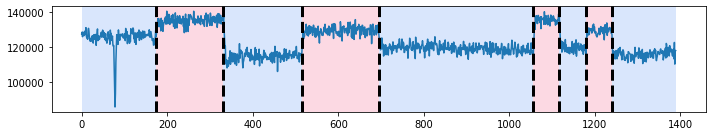

In [91]:
fig, ax_arr = rpt.display(well_log[start_t:end_t], predicted_bkps, predicted_bkps)

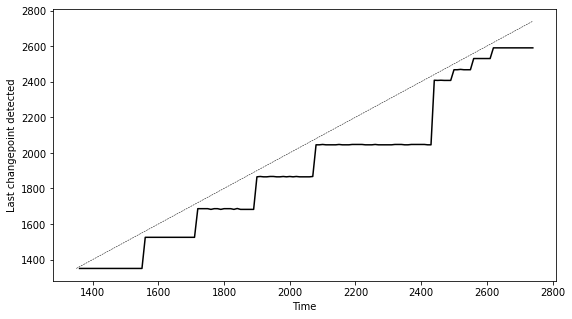

In [92]:
plt.figure(figsize=(9,5))
plt.plot(list_t, list_end_bkps, color='k')
plt.plot(np.arange(start_t, end_t), np.arange(start_t, end_t), linewidth=0.5, color='k', linestyle = '--')
plt.xlabel('Time')
plt.ylabel('Last changepoint detected')
plt.show()

In [93]:
new_change_point_t = np.argwhere((np.abs(list_end_bkps[1:] - list_end_bkps[:-1]) >10)).flatten()
list_end_bkps[new_change_point_t+1] - np.array(list_t)[new_change_point_t]

array([-25, -24, -25, -25, -22, -23, -20, -20])